## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### Slow Ahead!

If you're running without a GPU, this notebook can take a full day and night to run. Training these systems takes time!

## Bonus Chapter 3 - Notebook 4: CNNs

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils
import numpy as np

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 42
np.random.seed(random_seed)

In [5]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [6]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [-1, 1]
X_train = np.interp(X_train, [0, 255], [-1,1])
X_test = np.interp(X_test, [0, 255], [-1,1])

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

In [7]:
# Make the different CNN models we use in this chapter

def make_simple_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5),
                     activation='relu', padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_bigger_cnn_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pooling_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3))) 
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     strides=(2, 2), kernel_constraint=maxnorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                     strides=(2, 2), kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_batchnorm_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation=None, padding='same',
                     strides=(2, 2), 
                     input_shape=(image_height, image_width, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_1_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_2_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

In [8]:
def run_model(model_maker, plot_title, filename):
    model = model_maker()
    np.random.seed(random_seed)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                     epochs=100, batch_size=256)
    plot_accuracy_and_loss(history, plot_title, filename)
    return history

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 21s 348us/step - loss: 0.2657 - accuracy: 0.9219 - val_loss: 0.0987 - val_accuracy: 0.9721
Epoch 2/100
60000/60000 [==============================] - 20s 337us/step - loss: 0.0806 - accuracy: 0.9766 - val_loss: 0.0660 - val_accuracy: 0.9803
Epoch 3/100
60000/60000 [==============================] - 21s 346us/step - loss: 0.0583 - accuracy: 0.9825 - val_loss: 0.0616 - val_accuracy: 0.9807
Epoch 4/100
60000/60000 [==============================] - 19s 315us/step - loss: 0.0465 - accuracy: 0.9861 - val_loss: 0.0537 - val_accuracy: 0.9836
Epoch 5/100
60000/60000 [==============================] - 19s 315us/step - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.0590 - val_accuracy: 0.9823
Epoch 6/100
60000/60000 [==============================] - 19s 313us/step - loss: 0.0323 - accuracy: 0.9897 - val_loss: 0.0584 - val_accuracy: 0.9829
Epoch 7/100
60000/60000 [=========================

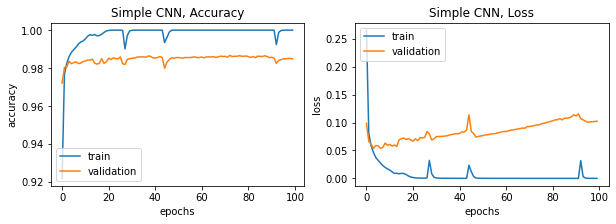

In [9]:
simple_history = run_model(
    make_simple_cnn_model, 'Simple CNN', 'Simple-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 79s 1ms/step - loss: 0.3977 - accuracy: 0.8837 - val_loss: 0.1006 - val_accuracy: 0.9701
Epoch 2/100
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1076 - accuracy: 0.9677 - val_loss: 0.0702 - val_accuracy: 0.9785
Epoch 3/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0825 - accuracy: 0.9749 - val_loss: 0.0574 - val_accuracy: 0.9805
Epoch 4/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0708 - accuracy: 0.9780 - val_loss: 0.0550 - val_accuracy: 0.9812
Epoch 5/100
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0616 - accuracy: 0.9810 - val_loss: 0.0485 - val_accuracy: 0.9839
Epoch 6/100
60000/60000 [==============================] - 75s 1ms/step - loss: 0.0556 - accuracy: 0.9826 - val_loss: 0.0442 - val_accuracy: 0.9849
Epoch 7/100
60000/60000 [==============================] - 65s

Epoch 56/100
60000/60000 [==============================] - 77s 1ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0432 - val_accuracy: 0.9882
Epoch 57/100
60000/60000 [==============================] - 75s 1ms/step - loss: 0.0119 - accuracy: 0.9956 - val_loss: 0.0468 - val_accuracy: 0.9875
Epoch 58/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0127 - accuracy: 0.9953 - val_loss: 0.0478 - val_accuracy: 0.9876
Epoch 59/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0124 - accuracy: 0.9956 - val_loss: 0.0459 - val_accuracy: 0.9871
Epoch 60/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0119 - accuracy: 0.9959 - val_loss: 0.0534 - val_accuracy: 0.9874
Epoch 61/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0115 - accuracy: 0.9959 - val_loss: 0.0482 - val_accuracy: 0.9877
Epoch 62/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0118 - accuracy: 0.9957

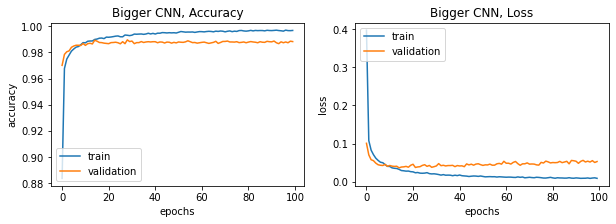

In [10]:
bigger_history = run_model(
    make_bigger_cnn_model, 'Bigger CNN', 'Bigger-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 147s 2ms/step - loss: 0.3376 - accuracy: 0.9023 - val_loss: 0.1005 - val_accuracy: 0.9738
Epoch 2/100
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0811 - accuracy: 0.9747 - val_loss: 0.0738 - val_accuracy: 0.9822
Epoch 3/100
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0605 - accuracy: 0.9808 - val_loss: 0.0617 - val_accuracy: 0.9824
Epoch 4/100
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0486 - accuracy: 0.9844 - val_loss: 0.0498 - val_accuracy: 0.9868
Epoch 5/100
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.0495 - val_accuracy: 0.9846
Epoch 6/100
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0350 - accuracy: 0.9892 - val_loss: 0.0372 - val_accuracy: 0.9898
Epoch 7/100
60000/60000 [==============================]

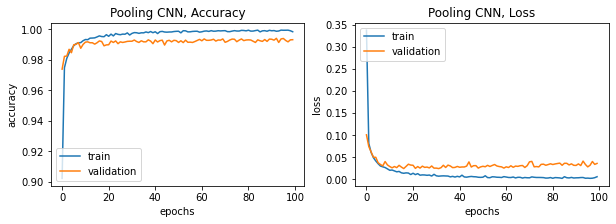

In [11]:
pooling_history = run_model(
    make_pooling_cnn_model, 'Pooling CNN', 'Pooling-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 36s 602us/step - loss: 0.4610 - accuracy: 0.8574 - val_loss: 0.1094 - val_accuracy: 0.9665
Epoch 2/100
60000/60000 [==============================] - 36s 600us/step - loss: 0.1259 - accuracy: 0.9605 - val_loss: 0.0648 - val_accuracy: 0.9805
Epoch 3/100
60000/60000 [==============================] - 37s 616us/step - loss: 0.0956 - accuracy: 0.9703 - val_loss: 0.0530 - val_accuracy: 0.9820
Epoch 4/100
60000/60000 [==============================] - 35s 581us/step - loss: 0.0769 - accuracy: 0.9765 - val_loss: 0.0485 - val_accuracy: 0.9833
Epoch 5/100
60000/60000 [==============================] - 35s 582us/step - loss: 0.0661 - accuracy: 0.9786 - val_loss: 0.0439 - val_accuracy: 0.9862
Epoch 6/100
60000/60000 [==============================] - 37s 611us/step - loss: 0.0597 - accuracy: 0.9811 - val_loss: 0.0375 - val_accuracy: 0.9890
Epoch 7/100
60000/60000 [=========================

Epoch 55/100
60000/60000 [==============================] - 34s 574us/step - loss: 0.0092 - accuracy: 0.9967 - val_loss: 0.0358 - val_accuracy: 0.9906
Epoch 56/100
60000/60000 [==============================] - 35s 578us/step - loss: 0.0110 - accuracy: 0.9961 - val_loss: 0.0306 - val_accuracy: 0.9921
Epoch 57/100
60000/60000 [==============================] - 34s 572us/step - loss: 0.0089 - accuracy: 0.9968 - val_loss: 0.0315 - val_accuracy: 0.9920
Epoch 58/100
60000/60000 [==============================] - 34s 566us/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0296 - val_accuracy: 0.9918
Epoch 59/100
60000/60000 [==============================] - 34s 575us/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.0308 - val_accuracy: 0.9920
Epoch 60/100
60000/60000 [==============================] - 34s 565us/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.0303 - val_accuracy: 0.9921
Epoch 61/100
60000/60000 [==============================] - 34s 570us/step - loss: 0.0089 - ac

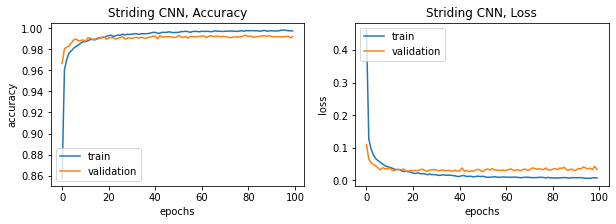

In [12]:
striding_history = run_model(
    make_striding_cnn_model, 'Striding CNN', 'Striding-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 55s 915us/step - loss: 0.2722 - accuracy: 0.9187 - val_loss: 0.2082 - val_accuracy: 0.9493
Epoch 2/100
60000/60000 [==============================] - 57s 948us/step - loss: 0.0659 - accuracy: 0.9801 - val_loss: 0.0594 - val_accuracy: 0.9809
Epoch 3/100
60000/60000 [==============================] - 56s 941us/step - loss: 0.0460 - accuracy: 0.9859 - val_loss: 0.0550 - val_accuracy: 0.9820
Epoch 4/100
60000/60000 [==============================] - 57s 947us/step - loss: 0.0344 - accuracy: 0.9897 - val_loss: 0.0640 - val_accuracy: 0.9789
Epoch 5/100
60000/60000 [==============================] - 58s 968us/step - loss: 0.0254 - accuracy: 0.9922 - val_loss: 0.0539 - val_accuracy: 0.9834
Epoch 6/100
60000/60000 [==============================] - 53s 875us/step - loss: 0.0205 - accuracy: 0.9933 - val_loss: 0.0528 - val_accuracy: 0.9826
Epoch 7/100
60000/60000 [=========================

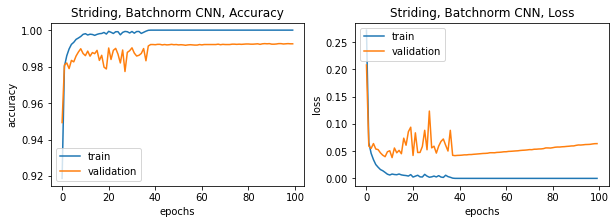

In [13]:
striding_batchnorm_history = run_model(
        make_striding_batchnorm_cnn_model, 
        'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 60s 1ms/step - loss: 0.2612 - accuracy: 0.9176 - val_loss: 0.0618 - val_accuracy: 0.9804
Epoch 2/100
60000/60000 [==============================] - 59s 981us/step - loss: 0.0617 - accuracy: 0.9804 - val_loss: 0.0704 - val_accuracy: 0.9792
Epoch 3/100
60000/60000 [==============================] - 59s 982us/step - loss: 0.0448 - accuracy: 0.9854 - val_loss: 0.0375 - val_accuracy: 0.9876
Epoch 4/100
60000/60000 [==============================] - 59s 984us/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.0342 - val_accuracy: 0.9889
Epoch 5/100
60000/60000 [==============================] - 59s 983us/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.0485 - val_accuracy: 0.9868
Epoch 6/100
60000/60000 [==============================] - 59s 982us/step - loss: 0.0254 - accuracy: 0.9916 - val_loss: 0.0358 - val_accuracy: 0.9890
Epoch 7/100
60000/60000 [===========================

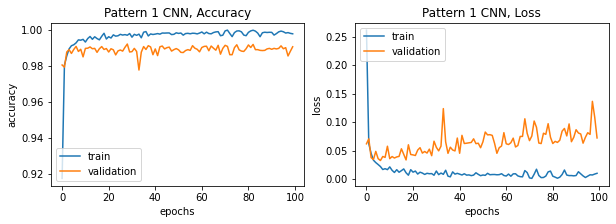

In [14]:
pattern_1_history = run_model(
        make_pattern_1_cnn_model, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 48s 808us/step - loss: 0.2589 - accuracy: 0.9219 - val_loss: 0.1226 - val_accuracy: 0.9592
Epoch 2/100
60000/60000 [==============================] - 47s 777us/step - loss: 0.0989 - accuracy: 0.9690 - val_loss: 0.0937 - val_accuracy: 0.9729
Epoch 3/100
60000/60000 [==============================] - 47s 784us/step - loss: 0.0724 - accuracy: 0.9774 - val_loss: 0.0776 - val_accuracy: 0.9755
Epoch 4/100
60000/60000 [==============================] - 47s 782us/step - loss: 0.0582 - accuracy: 0.9813 - val_loss: 0.0774 - val_accuracy: 0.9779
Epoch 5/100
60000/60000 [==============================] - 47s 784us/step - loss: 0.0501 - accuracy: 0.9841 - val_loss: 0.0810 - val_accuracy: 0.9761
Epoch 6/100
60000/60000 [==============================] - 47s 777us/step - loss: 0.0426 - accuracy: 0.9858 - val_loss: 0.0696 - val_accuracy: 0.9793
Epoch 7/100
60000/60000 [=========================

Epoch 55/100
60000/60000 [==============================] - 44s 740us/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.1100 - val_accuracy: 0.9816
Epoch 56/100
60000/60000 [==============================] - 44s 739us/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.0990 - val_accuracy: 0.9833
Epoch 57/100
60000/60000 [==============================] - 44s 736us/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0920 - val_accuracy: 0.9840
Epoch 58/100
60000/60000 [==============================] - 44s 738us/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0913 - val_accuracy: 0.9834
Epoch 59/100
60000/60000 [==============================] - 44s 739us/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.1294 - val_accuracy: 0.9803
Epoch 60/100
60000/60000 [==============================] - 44s 740us/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0950 - val_accuracy: 0.9828
Epoch 61/100
60000/60000 [==============================] - 44s 739us/step - loss: 0.0047 - ac

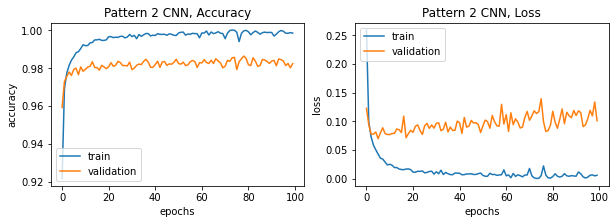

In [15]:
pattern_2_history = run_model(
        make_pattern_2_cnn_model, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')

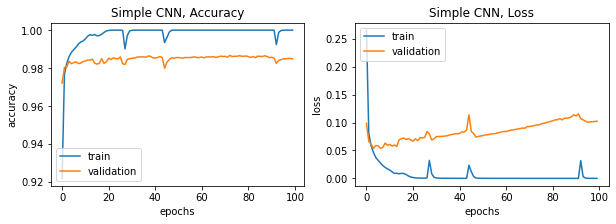

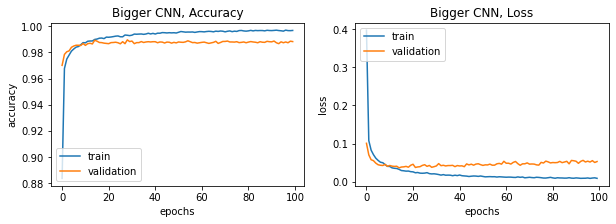

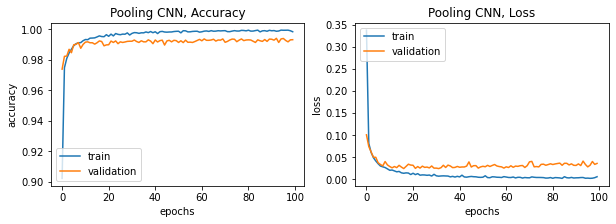

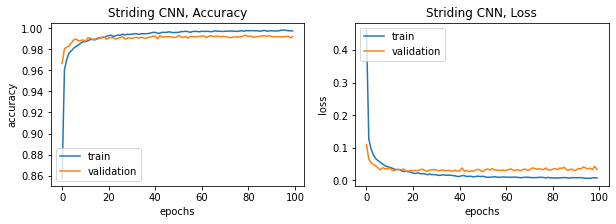

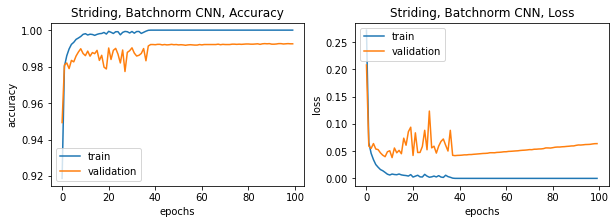

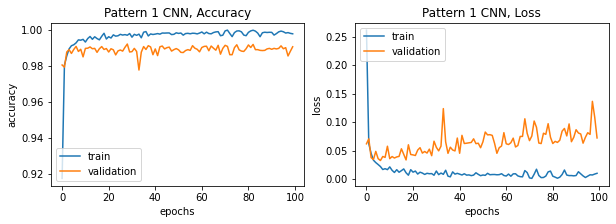

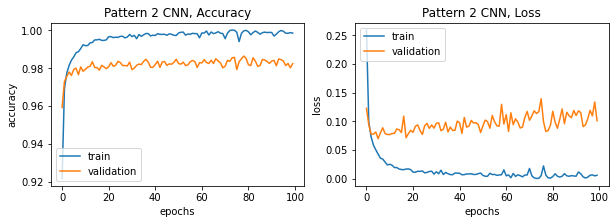

In [16]:
# get the plots by themselves
plot_accuracy_and_loss(simple_history, 'Simple CNN', 'Simple-CNN-graphs')
plot_accuracy_and_loss(bigger_history, 'Bigger CNN', 'Bigger-CNN-graphs')
plot_accuracy_and_loss(pooling_history, 'Pooling CNN', 'Pooling-CNN-graphs')
plot_accuracy_and_loss(striding_history, 'Striding CNN', 'Striding-CNN-graphs')
plot_accuracy_and_loss(striding_batchnorm_history, 'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')
plot_accuracy_and_loss(pattern_1_history, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')
plot_accuracy_and_loss(pattern_2_history, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')